# <font  color = "#0093AF">Pseudo-Contact Shift</font>

In the previous section, we investigated the [contact shift](../Chapter5/Ch5_ContactShift.ipynb), which results from an isotropic hyperfine coupling to a fast-relaxing electron. However, if the coupling is dipolar in nature, then we instead have a pseudo-contact shift. Under static conditions, the pseudo-contact shift appears just from a dipolar hyperfine coupling, but under tumbling or MAS, this vanishes unless the electron has an anisotropic g-tensor. We show how to simulate this effect here.

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

The shift in the NMR peak due to an isotropic coupling to a polarized electron is known as the contact shift. The pseudo-contact shift, on the other hand, results from the anisotropic part of the coupling to the electron. The anisotropic hyperfine coupling's Hamiltonian has an average of zero when sampling all orientations, however. This means that isotropic tumbling or MAS would in principal remove the hyperfine coupling (MAS can, in principle, leave spnning sidebands), even if the electron is polarized. Another factor comes in, however, which is the fact that the $g_{xz}$ and $g_{yz}$ components of the electron g-tensor may be large enough to tilt the electron's quantization axis away from the magnetic field's *z*-axis, such that MAS or isotropic tumbling no longer results in a complete averaging of the hyperfine Hamiltonian. Furthermore, the electron's polarization becomes orientation-dependent, which also hinders complete averaging of the pseudo-contact shift.

## Pseudo-contact shift without g-anisotropy
Without MAS or motion to average the coupling, a pseudo-contact shift (PCS) appears without g-tensor anisotropy, although the average shift is indeed zero. We start by simulating this case, showing the PCS under static conditions, and under tumbling or MAS.

### Build the system

In [3]:
delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
gxx=gyy=gzz=2
g_euler=[0,2*np.pi/5,0]

ex=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg=9)
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

L=ex.Liouvillian()

### Spectrum without relaxation

First, we just simulate the Pake pattern resulting from the dipolar hyperfine coupling without relaxation. We start from thermal equilibrium, in order to be able to see the asymmetry of the Pake pattern due to electron polarization. If we just start from '13Cx', no polarization is enforced on the electron.

In [4]:
Dt=0.00002
seq=L.Sequence(Dt=Dt)
Upi2=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2) #pi/2 along y

no_rlx=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*no_rlx
_=no_rlx.DetProp(seq,n=100)

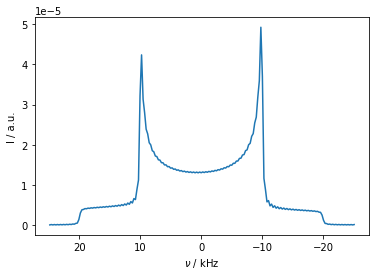

In [5]:
no_rlx.apod_pars['LB']=300
_=no_rlx.plot(FT=True,apodize=True)

### Spectrum with relaxation

In [6]:
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

rlx=sl.Rho(rho0='Thermal',detect='13Cp')

Upi2*rlx
_=rlx.DetProp(seq,n=100)

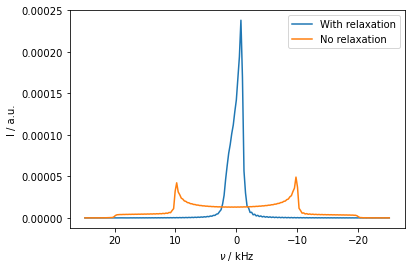

In [8]:
rlx.apod_pars['LB']=300
ax=rlx.plot(FT=True,apodize=True)
no_rlx.plot(FT=True,apodize=True,ax=ax)
_=ax.legend(('With relaxation','No relaxation'))

Then, we see that the Pake pattern collapses to the average of the two sides of the pattern. However, the average of the pseudo-contact shift is zero, and can be removed with moderate spinning, as shown below. Note that we change the powder average since the large number of angles are not required for MAS.

We re-initialize the experimental system (`ex`), since a number of settings get changed when adding MAS.

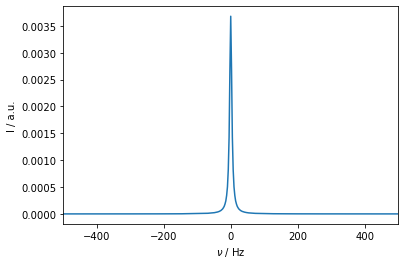

In [8]:
ex=sl.ExpSys(v0H=600,vr=5000,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg=3)
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

L=ex.Liouvillian()
Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence()

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)

ax=rho.plot(FT=True,apodize=True)
_=ax.set_xlim([-500,500])

Then, if include magic-angle spinning, the influence of the pseudo-contact shift is removed. Similarly, if the system undergoes isotropic tumbling, the pseudo-contact shift vanishes. We allow the system to hop around a tetrahedral geometry to mimic this behavior.

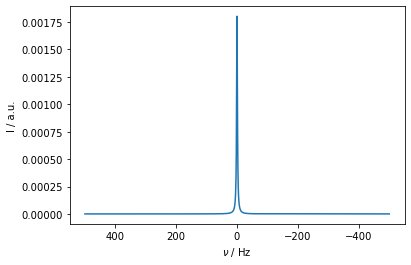

In [9]:
ex0=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=100,LF=False,pwdavg='alpha0beta0')
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

ex,kex=sl.Tools.SetupTumbling(ex0,q=1,tc=1e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence(Dt=1/1000)

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)

rho.plot(FT=True,apodize=True)
_=ax.set_xlim([-500,500])

## Pseudo-contact shift with g-anisotropy

Above, we saw that the pseudo-contact shift vanishes with MAS or isotropic motion. However, if a g-anisotropy is included, then the pseudo-contact shift reappears.

It is not sufficient to add the g-anisotropy in the rotating frame. The g-anisotropy induces a pseudo-contact shift because it changes the quantization axis of the electron away from the $z-$axis of the lab frame, *and* because the electron polarization varies as a function of the g-tensor orientation. The former effect is only induced if the computation is performed in the lab frame. In this case, we need to be careful not to forget to downmix the resulting signal. One may try also simulating in the rotating frame, to separate contributions from electron tilting and variation of the electron polarization.

The latter effect is only induced if we correctly implement relaxation. Since the electron quantization axis is no longer along *z*, then $T_1$ and $T_2$ relaxation need to be applied along the tilted axes, and the polarization needs to be readjusted depending on the g-tensor orientation. This requires using the `OS=True` option, along with the `Thermal=True` option for $T_1$ relaxation. 

We furthermore note that the electron $T_1$ must be faster than the tumbling: otherwise, the electron does not return to its quantization axis quickly enough to induce the pseudo-contact shift.

We use hopping around the 'rep10' powder average to mimic tumbling. This will not perfectly reproduce the solution-state PCS, partly because it does not include motion around the $\gamma$ angle, and also because not enough angles are included. Nonetheless, it is a good demonstrate of the PCS concept and its general behavior.

### Pseudo-contact shift with isotropic hopping

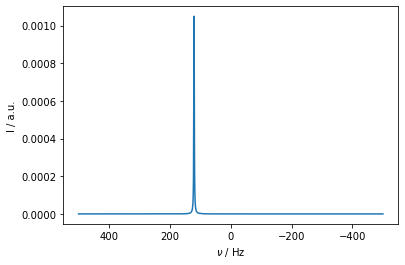

In [10]:
gxx,gyy,gzz=1,1,4
ex0=sl.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=298,LF=True,pwdavg='alpha0beta0')
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

ex,kex=sl.Tools.SetupTumbling(ex0,q=2,tc=5e-9) #This creates a system hopping around a tetrahedral geometry

L=sl.Liouvillian(ex,kex=kex)
L.add_relax(Type='T1',i=1,T1=1e-10,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-10,OS=True)

Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
seq=L.Sequence(Dt=1/1000)

rho=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2*rho
rho.DetProp(seq,n=1024)
rho.downmix()

ax=rho.plot(FT=True,apodize=True)

We can repeat the above calculation with decreasing temperature, to verify that the simulated PCS increases with decreasing temperature.

### Temperature dependence

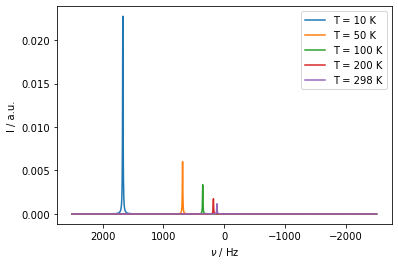

In [11]:
ax=plt.subplots()[1]
seq=L.Sequence(Dt=1/5000)

T=[10,50,100,200,298]
for T_K in T:
    L.expsys.T_K=T_K
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=1024)
    rho.downmix()
    
    rho.plot(FT=True,apodize=True,ax=ax)
_=ax.legend([f'T = {T_K:.0f} K' for T_K in T])

Indeed, the expected temperature dependence is obtained. 

Note that the pseudo-contact shift depends on the electron's polarization and quantization axis changing for different orientations. If the electron $T_1$ is longer than the rate of reorientation (from tumbling or MAS), the pseudo-contact shift is reduced, because the electron does not have time to fully requilibrate at each new orientation. We repeat the above calculation with a longer electron $T_1$ to see the effects.

### Electron $T_1$ dependence

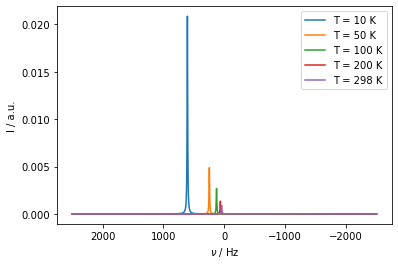

In [12]:
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-8,OS=True,Thermal=True)
L.add_relax(Type='T2',i=1,T2=1e-10,OS=True)

ax=plt.subplots()[1]
seq=L.Sequence(Dt=1/5000)

T=[10,50,100,200,298]
for T_K in T:
    L.expsys.T_K=T_K
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=1024)
    rho.downmix()
    
    rho.plot(FT=True,apodize=True,ax=ax)
_=ax.legend([f'T = {T_K:.0f} K' for T_K in T])

The magnitude of the PCS is reduced, since the electron does not recover to its thermal equilibrium quickly when hopping to a new orientation.

### Orientation dependence of PCS

PCS has a complex orientation dependence, due to variation of the relative orientations of the g-tensor and hyperfine tensor, dependence on the location of the nuclear spin relative to the electron. Here, we calculate the size of the PCS for a 10 Angstrom distance as a function of the g-tensor orientation relative to the dipolar hyperfine coupling orientation.

In [5]:
# Sweep euler angles
sl.Defaults['verbose']=False
SZ=[15,30]
beta=np.linspace(0,np.pi/2,SZ[0])
gamma=np.linspace(0,np.pi*2,SZ[1])
N=beta.size*gamma.size

beta,gamma=np.meshgrid(beta,gamma)
shift=[]
for k,(beta0,gamma0) in enumerate(zip(beta.reshape(np.prod(SZ)),gamma.reshape(np.prod(SZ)))):
    ex0=sl.ExpSys(v0H=600,Nucs=['13C','e-'],LF=True,vr=0,T_K=100,pwdavg=sl.PowderAvg('alpha0beta0'))  #Electron-nuclear system
    ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
    ex0.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[0,beta0,gamma0])

    ex,kex=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=2) #1 ns tumbling

    L=sl.Liouvillian(ex,kex=kex)
    L.add_relax(Type='T1',i=1,T1=1e-11,OS=True,Thermal=True)
    L.add_relax(Type='T2',i=1,T2=1e-11,OS=True)

    seq=L.Sequence(Dt=1e-4)

    rho=sl.Rho('Thermal','13Cp')  #Generate initial state, detection operator
    Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
    (Upi2*rho).DetProp(seq,n=800) #Propagate the system
    rho.downmix()

    i=np.argmax(rho.FT[0])
    shift.append(rho.v_axis[i])
        
shift=np.array(shift).reshape([SZ[1],SZ[0]])

### 3D plot of the PCS magnitude

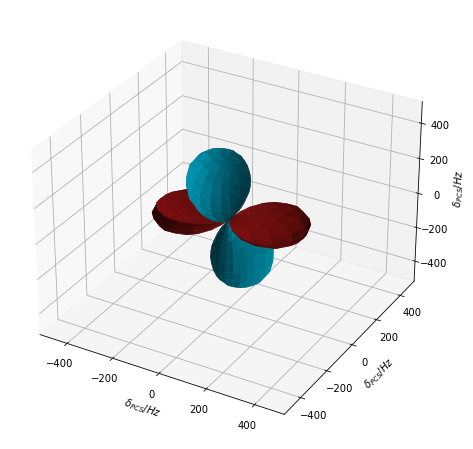

In [6]:
from copy import copy
x=shift*np.sin(beta)*np.cos(gamma)
y=shift*np.sin(beta)*np.sin(gamma)
z=shift*np.cos(beta)

ax=plt.figure(figsize=[8,8]).add_subplot(1,1,1,projection='3d')
i=shift>0

x0,y0,z0=copy(x),copy(y),copy(z)
for q in [x0,y0,z0]:q[i]=0
ax.plot_surface(x0,y0,z0,color='#801010')
ax.plot_surface(-x0,-y0,-z0,color='#801010')

x0,y0,z0=copy(x),copy(y),copy(z)
for q in [x0,y0,z0]:q[~i]=0
ax.plot_surface(x0,y0,z0,color="#0093AF")
ax.plot_surface(-x0,-y0,-z0,color="#0093AF")


# ax.plot_surface(x[~i],y[~i],z[~i])
for q in ['x','y','z']:
    getattr(ax,f'set_{q}lim')([-500,500])
    getattr(ax,f'set_{q}label')(r'$\delta_{PCS} / Hz$')

Then, we see that the sign and magnitude of the PCS varies depending on the relative orientations of the dipolar and g-tensors, resulting in different PCS depending on the position of the nucleas relative to the electron. The resulting shape is slightly tilted– this effect only comes when calculating in the lab frame. In the rotating frame, the shape is aligned along the axes, highlighting the importance of including lab-frame terms.

## Pseudo-contact Shift under MAS

Finally, we investigate how the PCS manifests under magic angle spinning. Due to the anistropic g-tensor, the PCS cannot be spun out, and furthermore, different crystallites in the rotor will have different shifts, yielding a complex, rank-4 lineshape.

### Run the simulation

In [10]:
delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=6000,LF=True,T_K=200,pwdavg=4,n_gamma=30)  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4)
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

L.add_relax('T1',i=1,T1=1e-7,OS=True,Thermal=True)  
L.add_relax('T2',i=1,T2=1e-7,OS=True)

seq=L.Sequence() #Generate an empty sequence

rho200=sl.Rho('13Cx','13Cp')  #Generate initial state, detection operator
_=rho200.DetProp(seq,n=8000,n_per_seq=1) #Propagate the system

### Plot the results

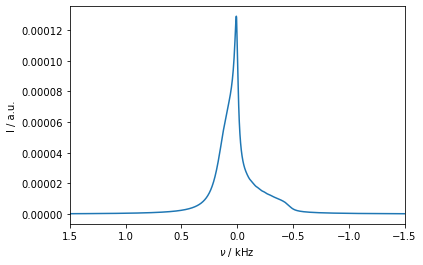

In [11]:
rho200.downmix()
ax=rho200.plot(FT=True) #Plot the results into the same axis
_=ax.set_xlim([1.5,-1.5])

A complex lineshape is obtained, resulting from incomplete averaging of the rank-4 PCS tensor. As with isotropic hopping, decreasing the temperature will increasing the magnitude of the PCS, as shown below.

### Temperature dependence

In [12]:
delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=6000,LF=True,T_K=100,pwdavg=4,n_gamma=30)  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4)
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

L.add_relax('T1',i=1,T1=1e-7,OS=True,Thermal=True)  #1 microsecond T1
L.add_relax('T2',i=1,T2=1e-7,OS=True) #1 ns T2, required for physical system when T1 is present

seq=L.Sequence() #Generate an empty sequence

rho100=sl.Rho('13Cx','13Cp')  #Generate initial state, detection operator
_=rho100.DetProp(seq,n=8000,n_per_seq=1) #Propagate the system

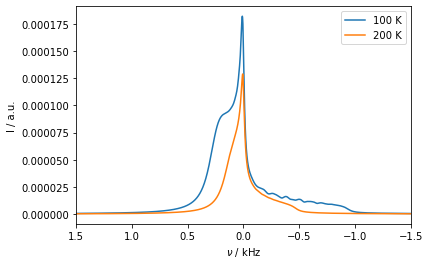

In [13]:
rho100.downmix()
ax=rho100.plot(FT=True) #Plot the results into the same axis
rho200.plot(FT=True,ax=ax)
ax.legend(('100 K','200 K'))
_=ax.set_xlim([1.5,-1.5])

The same tensor shape is obtained, but it is now twice as broad (it also has more signal from the lower temperature). 

Finally, we observe how the PCS tensor shape depends on the relative orientation of the dipolar- and g-tensors.

### Re-orient the g-tensor

In [8]:
delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=6000,LF=True,T_K=200,pwdavg=4,n_gamma=30)  #Electron-nuclear system
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[0,np.pi/2,np.pi/5])
    
L=sl.Liouvillian(ex)        #Generate a Liouvillian

L.add_relax('T1',i=1,T1=1e-7,OS=True,Thermal=True)  
L.add_relax('T2',i=1,T2=1e-7,OS=True)

seq=L.Sequence() #Generate an empty sequence

rho=sl.Rho('13Cx','13Cp')  #Generate initial state, detection operator
_=rho.DetProp(seq,n=8000,n_per_seq=1) #Propagate the system

### Plot the results

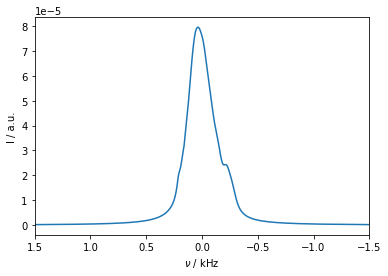

In [9]:
rho.downmix()
ax=rho.plot(FT=True) #Plot the results into the same axis
_=ax.set_xlim([1.5,-1.5])